In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [4]:
key = jax.random.PRNGKey(0)

In [5]:
from mrfx.models import GUM
from mrfx.samplers import GUMSampler

## Timing experiments

Given a $\kappa$ we empirically look for the corresponding $\beta$ in a Pott's model, in terms of global appearance of the simulated field.

In [6]:
kappa = 0.1

We need to find what is the equivalent $\beta$ for this $\kappa$. We do it experimentally. Let us simulate many discretized GUMs for the fixed $\kappa$ and average the estimated $\beta$ over them:

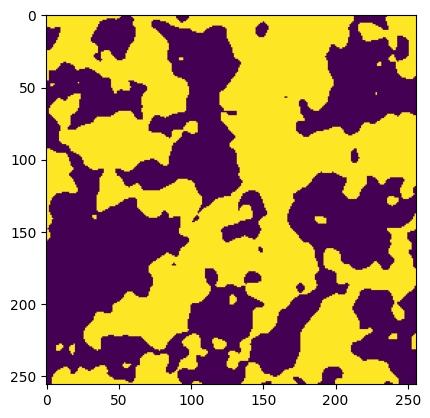

In [7]:
gum = GUM(kappa=kappa, K=2, dim=2)
gum_sampler = GUMSampler(n_bands=2500, lx=256, ly=256, method="spectral")
key, subkey = jax.random.split(key, 2)
gum_x = gum_sampler.sample_image(gum, subkey)[0]
plt.imshow(gum_x)
plt.show()

In [8]:
# from mrfx.samplers._utils import get_neigh

# neigh_size = 1
# def est_alpha(Xt):
#     K = jnp.unique(Xt).shape[0]
#     P,Q = Xt.shape
#     t=0
#     def get_local_sum(Xt, u, v, Q, P):
#         neigh = get_neigh(Xt, u, v, Q, P, neigh_size)
#         return jnp.sum(neigh == Xt[u, v])
#     v_get_local_sum = jax.vmap(
#         jax.vmap(
#             get_local_sum, (None, 0, None, None, None)
#         ), (None, None, 0, None, None)
#     )
#     t = jnp.sum(v_get_local_sum(Xt, jnp.arange(Q), jnp.arange(P), Q, P))

#     freq=t/((2 * neigh_size + 1) ** 2 *(P)*(Q))
#     alpha=(K**2/(2*(K-1)))*(freq-(1/K))
#     return alpha

# alphas = []

# for Xt in gums_x:
#     alphas.append(est_alpha(Xt))

# alpha = jnp.mean(jnp.asarray(alphas))
# print(alpha)

In [9]:
from mrfx.experiments import time_complete_sampling, plot_benchmark

key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 8)
sizes = [(2**e, 2**e) for e in range(4, 10)]
times, _, _, energy = time_complete_sampling(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=100,
    kwargs_sampler={"method": "fourier"},
    kwargs_model={"kappa": kappa, "dim": 2},
    exp_name="GUMSampler_fourier_GPU",
    with_energy=True,
    with_jit=True,
    with_n_iter=False
)

[2025-09-04 17:05:54,731] [zeus.device.gpu.nvidia](nvidia.py:47) pynvml is available and initialized.
[2025-09-04 17:05:54,738] [zeus.device.cpu.rapl](rapl.py:137) RAPL directory (/sys/class/powercap/intel-rapl) is available.
[2025-09-04 17:05:54,739] [zeus.monitor.energy](energy.py:223) Monitoring GPU indices [0].
[2025-09-04 17:05:54,739] [zeus.monitor.energy](energy.py:224) Monitoring CPU indices []
Rep ( / 100): 

/home/hugo/Documents/recherche/gum/code/mrfx/mrfx/experiments/_benchmark.py:208: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


[2025-09-04 17:05:55,641] [zeus.utils.framework](framework.py:47) JAX with CUDA support is available.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

/home/hugo/anaconda3/envs/gum/lib/python3.11/site-packages/zeus/monitor/energy.py:435: UserWarning: The energy consumption of one or more GPUs was measured as zero. This means that the time duration of the measurement window was shorter than the GPU's energy counter update period. Consider turning on the `approx_instant_energy` option in `ZeusMonitor`, which approximates the energy consumption of a short time window as instant power draw x window duration.
  warnings.warn(


33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=np.int32(2), lx=16, ly=16, compilation_time=0.8994038105010986,runtime_mean=[np.float64(0.005064663887023926)], energy_mean=[np.float64(0.015579999999899882)]
Rep ( / 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=np.int32(2), lx=32, ly=32, compilation_time=0.9649016857147217,runtime_mean=[np.float64(0.005064663887023926), np.float64(0.004771697521209717)], energy_mean=[np.float64(0.015579999999899882), np.float64(0.012599999999947613)]
Rep ( / 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31

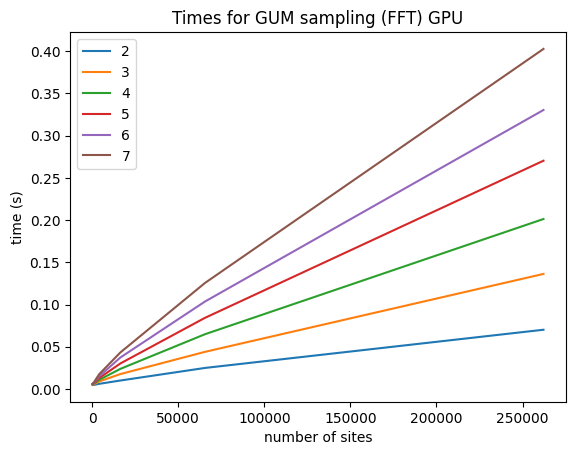

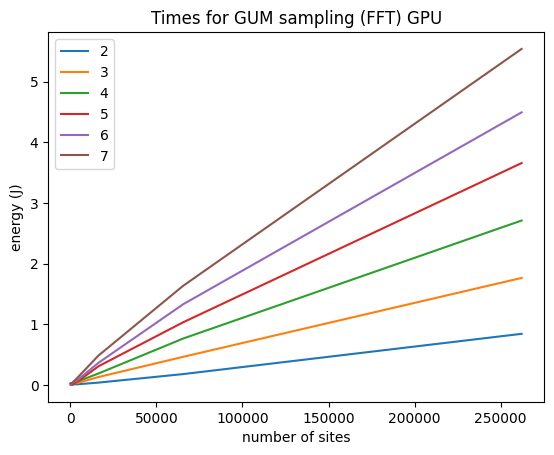

In [10]:
from mrfx.experiments import plot_benchmark

plot_benchmark(Ks, sizes, times, title="Times for GUM sampling (FFT) GPU", ylabel="time (s)")
plot_benchmark(Ks, sizes, energy, title="Times for GUM sampling (FFT) GPU", ylabel="energy (J)")

In [12]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 8)
sizes = [(2**e, 2**e) for e in range(4, 10)]
times, _, _, energy = time_complete_sampling(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=100,
    kwargs_sampler={"n_bands": 1500, "method": "spectral"},
    kwargs_model={"kappa": 0.05, "dim": 2},
    exp_name="GUMSampler_spectral_GPU",
    with_energy=True,
    with_jit=True,
    with_n_iter=False
)

[2025-09-04 17:12:09,056] [zeus.monitor.energy](energy.py:223) Monitoring GPU indices [0].
[2025-09-04 17:12:09,057] [zeus.monitor.energy](energy.py:224) Monitoring CPU indices []
Rep ( / 100): 

/home/hugo/Documents/recherche/gum/code/mrfx/mrfx/experiments/_benchmark.py:208: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/anaconda3/envs/gum/lib/python3.11/site-packages/zeus/monitor/energy.py:435: UserWarning: The energy consumption of one or more GPUs was measured as zero. This means that the time duration of the measurement window was shorter than the GPU's energy counter update period. Consider turning on the `approx_instant_energy` option in `ZeusMonitor`, which approximates the energy consumption of a short time window as instant power draw x window duration.
  warnings.warn(


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=np.int32(2), lx=16, ly=16, compilation_time=2.397512912750244,runtime_mean=[np.float64(0.0045902299880981445)], energy_mean=[np.float64(0.01742000000012922)]
Rep ( / 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=np.int32(2), lx=32, ly=32, compilation_time=2.376302480697632,runtime_mean=[np.float64(0.0045902299880981445), np.float64(0.004589619636535644)], energy_mean=[np.float64(0.01742000000012922), np.float64(0.01319999999992433)]
Rep ( / 100):

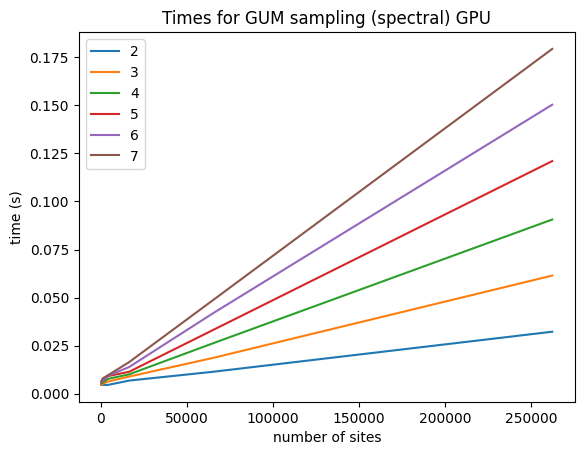

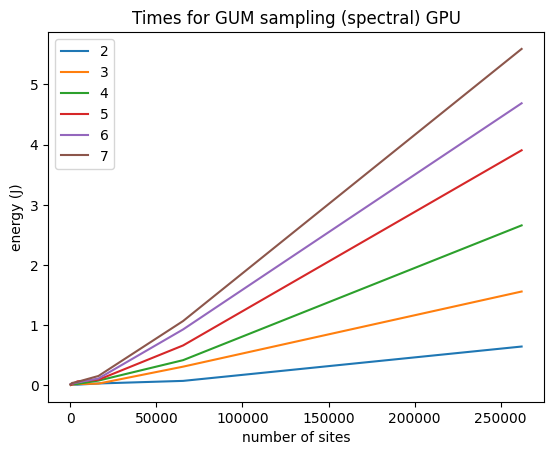

In [13]:
from mrfx.experiments import plot_benchmark

plot_benchmark(Ks, sizes, times, title="Times for GUM sampling (spectral) GPU", ylabel="time (s)")
plot_benchmark(Ks, sizes, energy, title="Times for GUM sampling (spectral) GPU", ylabel="energy (J)")

## Compute statistics 

In [9]:
def compute_stats(samples):
    for k in range(len(samples)):
        p_x_0 = 0
        for X in samples[k][0]:
            p_x_0 += (X == 0).mean()
        p_x_0 /= len(samples[k][0])
        std_p_x_0 = 0
        for X in samples[k][0]:
            std_p_x_0 += (p_x_0 - (X == 0).mean()) ** 2
        std_p_x_0 /= len(samples[k][0])
        std_p_x_0 = np.sqrt(std_p_x_0)
        print(Ks[k], p_x_0, std_p_x_0)

In [107]:
kappa = 0.1

In [108]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 6)
sizes = [(150, 150)]
times, _, samples_gum_fourier = time_complete_sampling(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=50,
    kwargs_sampler={"method": "fourier"},
    kwargs_model={"kappa": kappa, "dim": 2},
    return_X=True,
    with_jit=True
)

/tmp/ipykernel_28807/273311803.py:58: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=2, lx=150, ly=150, compilation_time=0.7416555881500244, runtime_mean=0.019952826499938965
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=3, lx=150, ly=150, compilation_time=1.453150749206543, runtime_mean=0.03868039608001709
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=4, lx=150, ly=150, compilation_time=1.8645656108856201, runtime_mean=0.05725152969360352
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=5, lx=150, ly=150, compilation_time=2.494184970855713, runtime_mean=0.06850856304168701


In [109]:
compute_stats(samples_gum_fourier)

2 0.51566845 0.079194866
3 0.31426933 0.08641417
4 0.2511449 0.06563941
5 0.19680625 0.059682623


In [110]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 6)
sizes = [(150, 150)]
times, _, samples_gum_spectral = time_complete_sampling(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=50,
    kwargs_sampler={"method": "spectral", "n_bands": 2500},
    kwargs_model={"kappa": kappa, "dim": 2},
    return_X=True,
    with_jit=True
)

Rep ( / 50), 

/tmp/ipykernel_28807/273311803.py:58: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=2, lx=150, ly=150, compilation_time=1.6276123523712158, runtime_mean=0.006027822494506836
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=3, lx=150, ly=150, compilation_time=3.035806894302368, runtime_mean=0.009676198959350586
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=4, lx=150, ly=150, compilation_time=5.097198724746704, runtime_mean=0.014292569160461425
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=5, lx=150, ly=150, compilation_time=7.6165995597839355, runtime_mean=0.01895233154296875


In [111]:
compute_stats(samples_gum_spectral)

2 0.5036071 0.09351455
3 0.32956356 0.077955835
4 0.25343648 0.071078934
5 0.19946665 0.04809223


In [120]:
from functools import partial
from mrfx.samplers._utils import euclidean_dist


@partial(jax.jit, static_argnames=["lx", "ly", "distance_function"])
def get_neigh_at_d(xy, d, X, lx, ly, distance_function):
    """
    from a pixel (x,y) get the values of all the neighbors at distance d
    """
    ind = jnp.dstack(jnp.meshgrid(jnp.arange(lx), jnp.arange(ly))).reshape((-1, 2))
    v_eval = jax.vmap(
        lambda all_x_y: distance_function(
            x1=xy[0], x2=all_x_y[0], y1=xy[1], y2=all_x_y[1], lx=lx, ly=ly
        )
    )
    dists = v_eval(ind).squeeze()
    return jnp.where(
        jnp.logical_and(dists <= d + 0.1, dists >= d - 0.1), X.flatten(), jnp.nan
    )


def compute_proba_with_d(samples, lx, ly, exp_name=None):
    distances = jnp.arange(0, 50)

    ind = jnp.dstack(jnp.meshgrid(jnp.arange(lx), jnp.arange(ly))).reshape((-1, 2))

    avg_on_samples = jnp.zeros(distances.shape)
    reps = 10
    for i in range(reps):

        def compute_proba_at_d(carry, d):  # , X, lx, ly):
            (X,) = carry

            def compute_proba_at_d_one_site(xy, d):
                neigh_at_d = get_neigh_at_d(xy, d, X, lx, ly, euclidean_dist)
                # idx_neigh_at_d = jnp.nonzero(~jnp.isnan(neigh_at_d), size=lx*ly, fill_value=jnp.nan)
                return jnp.sum(
                    jnp.logical_and(
                        neigh_at_d == X[xy[1], xy[0]],  # careful with indexing here!
                        ~jnp.isnan(neigh_at_d),
                    )
                ) / jnp.sum(~jnp.isnan(neigh_at_d))

            v_compute_proba_at_d_one_site = jax.vmap(
                compute_proba_at_d_one_site, (0, None)
            )
            res = v_compute_proba_at_d_one_site(ind, d)
            return (X,), jnp.mean(res)

        # scan because we must handle d sequentially otherwise RAM explodes
        _, probas_at_d = jax.lax.scan(
            compute_proba_at_d, (samples[0][0][i],), distances
        )
        avg_on_samples += probas_at_d
    # v_compute_proba_at_d = jax.vmap(compute_proba_at_d, (0, None, None, None))
    # return v_compute_proba_at_d(distances, samples[0][0][0], 100, 100)
    print(avg_on_samples / reps)
    if exp_name is not None:
        df = pd.DataFrame(
            {"d": distances} | {"proba_equal_at_d": avg_on_samples / reps}
        )
        df.to_csv(f"{exp_name}.csv", index=False)
    return avg_on_samples / reps

In [121]:
with jax.default_device(jax.devices("cpu")[0]):
    probas_with_d_gum_fourier = compute_proba_with_d(
        samples_gum_fourier, 150, 150, "proba_with_d_GUM_Fourier"
    )
    probas_with_d_gum_spectral = compute_proba_with_d(
        samples_gum_spectral, 150, 150, "proba_with_d_GUM_Spectral"
    )

[1.         0.94426334 0.90261924 0.86721116 0.83639115 0.8078659
 0.7832657  0.76070833 0.74011624 0.7221586  0.70391953 0.6880337
 0.6715788  0.6580717  0.6458228  0.632337   0.6213178  0.60922223
 0.5994941  0.5908094  0.581757   0.5734445  0.5662815  0.5597662
 0.553478   0.54817885 0.5434413  0.53837097 0.5331429  0.5290296
 0.52597284 0.52231044 0.5192423  0.5157145  0.51426315 0.51137525
 0.5094064  0.5068808  0.50575054 0.5049054  0.50271666 0.5021339
 0.50114936 0.5009378  0.5004881  0.49906725 0.49929342 0.49803457
 0.4976921  0.49743885]
[1.         0.9637537  0.92836857 0.89454854 0.86265564 0.8322755
 0.8045877  0.7802293  0.75793946 0.73844814 0.71965086 0.7019452
 0.68651515 0.67236245 0.6597562  0.6475629  0.636958   0.6252246
 0.6161981  0.60840285 0.5997287  0.59155256 0.58433855 0.5774437
 0.57066643 0.5646264  0.55888486 0.5533503  0.5468608  0.5428357
 0.53863597 0.53350425 0.53024113 0.5249878  0.52428275 0.5200658
 0.5167757  0.51240504 0.5122628  0.5103194  0.50

In [10]:
import jax
from mrfx.experiments import time_complete_sampling, plot_benchmark
from mrfx.samplers import ChromaticGibbsSampler
from mrfx.models import Potts

key = jax.random.PRNGKey(0)

K = 2
beta = 1.0
potts_model = Potts(K, beta, neigh_size=1)

Ks = np.arange(2, 6)
sizes = [(150, 150)]  # (2 ** e, 2 ** e) for e in range(8, 10)]
reps = 20

key, subkey = jax.random.split(key, 2)
times, n_iterations, samples_mrf_gibbs = time_complete_sampling(
    ChromaticGibbsSampler,
    Potts,
    subkey,
    Ks,
    sizes,
    reps,
    kwargs_sampler={
        "eps": 0.05,
        "max_iter": 10000,
        "color_update_type": "vmap_in_color",
    },
    kwargs_model={"beta": beta},
    return_X=True,
)

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/experiments/_benchmark.py:166: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(k, **kwargs_model)


Rep ( / 20): Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
1 Stopping Gibbs sampler, cause: Convergence criterion is reached
2 Stopping Gibbs sampler, cause: Convergence criterion is reached
3 Stopping Gibbs sampler, cause: Convergence criterion is reached
4 Stopping Gibbs sampler, cause: Convergence criterion is reached
5 Stopping Gibbs sampler, cause: Convergence criterion is reached
6 Stopping Gibbs sampler, cause: Convergence criterion is reached
7 Stopping Gibbs sampler, cause: Convergence criterion is reached
8 Stopping Gibbs sampler, cause: Convergence criterion is reached
9 Stopping Gibbs sampler, cause: Convergence criterion is reached
10 Stopping Gibbs sampler, cause: Convergence criterion is reached
11 Stopping Gibbs sampler, cause: Convergence criterion is reached
12 Stopping Gibbs sampler, cause: Convergence criterion is reached
13 Stopping Gibbs sampler, cause: Convergence criterion is reach

In [11]:
compute_stats(samples_mrf_gibbs)

2 0.49799338 0.039919782
3 0.34708664 0.05811511
4 0.24801333 0.050490137
5 0.1969089 0.050380606


In [127]:
with jax.default_device(jax.devices("cpu")[0]):
    probas_with_d_mrf_gibbs = compute_proba_with_d(
        samples_mrf_gibbs, 150, 150, "proba_with_d_mrf_gibbs"
    )

[1.         0.9213222  0.9067993  0.8879034  0.8694531  0.8506314
 0.8315169  0.8134492  0.79549116 0.77845925 0.7605251  0.7433598
 0.72572005 0.7098389  0.6951122  0.67898166 0.6657464  0.64948857
 0.6369712  0.62536824 0.6125442  0.6003811  0.58977216 0.5794475
 0.5698465  0.5612138  0.55335844 0.546246   0.5387188  0.53306466
 0.5279145  0.52254975 0.51855135 0.51400054 0.51154256 0.50835055
 0.5051171  0.5019113  0.500795   0.49914163 0.49618387 0.4950355
 0.4931399  0.49223366 0.49160576 0.48893166 0.49149713 0.48816928
 0.48749194 0.4876121 ]


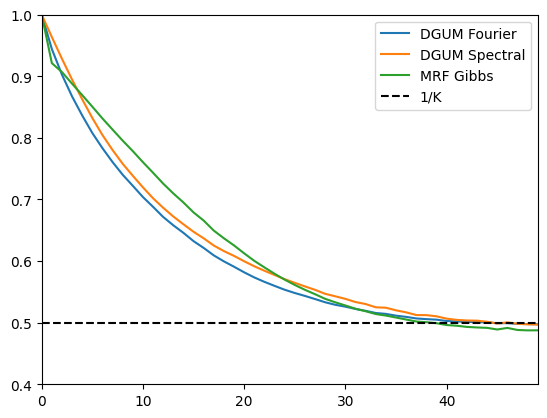

In [128]:
plt.rcParams.update({"font.size": 10})
distances = jnp.arange(0, 50)
title = "Empirical $p(x_i = x_j | \| i-j \| = d)$"
plt.ylim(1 / K - 0.1, 1)
plt.xlim(distances[0], distances[-1])
plt.plot(distances, probas_with_d_gum_fourier, label="DGUM Fourier")
plt.plot(distances, probas_with_d_gum_spectral, label="DGUM Spectral")
plt.plot(distances, probas_with_d_mrf_gibbs, label="MRF Gibbs")

plt.plot(distances, np.ones_like(distances) / 2, "--k", label="1/K")
plt.legend()
plt.savefig(f"{title}.pdf")